In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
import time
import numpy as np

###### This is a random seed to ensure all members of this experiment get the same train,test and validation set.

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

###### This is random data augmentation, this is optional

In [142]:
train_data = datasets.CIFAR10(root = 'data', 
                              train = True, 
                              download = True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255
'''
train_transforms = transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.RandomCrop(32, padding = 3),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.RandomCrop(32, padding = 3),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

'''

train_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

Files already downloaded and verified


###### Download and load the augmented data, we use CIFAR10 for this

In [143]:
train_data = datasets.CIFAR10('data', 
                              train = True, 
                              download = True,
                              transform = train_transforms)

test_data = datasets.CIFAR10('data', 
                             train = False, 
                             download = True,
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


###### Train validation Split, 90% of the data is used for training,the rest is used for validation

In [144]:
n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, 
                                                       [n_train_examples, n_valid_examples])

###### Each image is RGB, 32x32 sized

In [146]:
train_data[0][0].shape

torch.Size([3, 32, 32])

In [147]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


###### The torch way of shuffling data and splitting into batches, they are stored in an iterator which we can iterate over while training(or testing)

In [164]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size = BATCH_SIZE)

###### The Alexnet, slightly modified for our dataset.  The original takes a 277x277 size image. Our image is 32x32

In [165]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), #kernel_size
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

###### Create the model , it has 10 classes

In [166]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

###### A representation of Alexnet 

In [167]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [168]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


###### Try out different optimizers here

In [169]:
optimizer = optim.SGD(model.parameters(),lr=0.1)

###### Try different losses here, but for this particular data set, crossentropy is best left as is.

In [170]:
criterion = nn.CrossEntropyLoss()

###### Use Gpu if it is available

In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [172]:
model = model.to(device)
criterion = criterion.to(device)

###### Custom accuracy function, basically correct predictions/ total predictions

In [173]:
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

###### The function to train the model, classic structure found at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [174]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [175]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [176]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

###### Run the training and validation here, save the best model

In [177]:
EPOCHS = 10
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    
    #Here we save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    training_accuracies.append(train_acc)
    validation_accuracies.append(valid_acc)

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 2.089 | Train Acc: 19.41%
	 Val. Loss: 2.403 |  Val. Acc: 17.50%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 1.632 | Train Acc: 38.45%
	 Val. Loss: 1.523 |  Val. Acc: 44.54%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 1.347 | Train Acc: 50.98%
	 Val. Loss: 1.534 |  Val. Acc: 47.13%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 1.150 | Train Acc: 58.78%
	 Val. Loss: 2.369 |  Val. Acc: 40.17%
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.977 | Train Acc: 65.17%
	 Val. Loss: 1.481 |  Val. Acc: 53.90%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.843 | Train Acc: 70.31%
	 Val. Loss: 1.023 |  Val. Acc: 64.77%
Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.715 | Train Acc: 75.04%
	 Val. Loss: 2.703 |  Val. Acc: 44.54%
Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.612 | Train Acc: 78.57%
	 Val. Loss: 2.963 |  Val. Acc: 46.14%
Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.521 | Train Acc: 81.75%
	 Val. Loss: 1.030 |  Val. Acc: 68.02%
Epoch: 10 | Epoch T

###### Load the best model and test it

In [178]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.049 | Test Acc: 63.14%


###### Change above code to store results of different settings here

In [44]:
import matplotlib.pyplot as plt

###### Setting 1: Using RELU, Dropout with Adam Optimizer (The standard default), call it RDA

In [43]:
RDA_tl = training_losses
RDA_vl = validation_losses
RDA_ta = training_accuracies
RDA_va = validation_accuracies

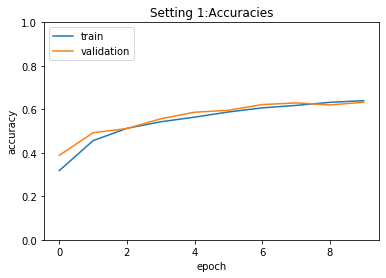

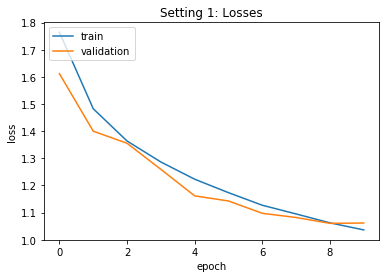

In [66]:
plt.ylim(0, 1)  
plt.plot(RDA_ta)
plt.plot(RDA_va)
plt.title('Setting 1:Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

 
plt.plot(RDA_tl)
plt.plot(RDA_vl)
plt.title('Setting 1: Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [103]:
# RMSProp is a bad optimizer where the accuracy doesnt go above 15%

###### Setting 2: Using Relu activation, with dropout and SGD Optimizer,call it RDS

In [134]:
RDS_tl = training_losses
RDS_vl = validation_losses
RDS_ta = training_accuracies
RDS_va = validation_accuracies

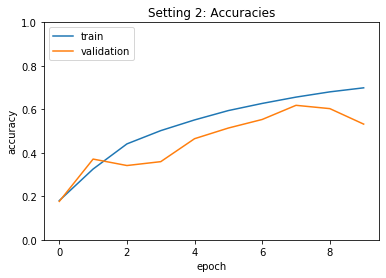

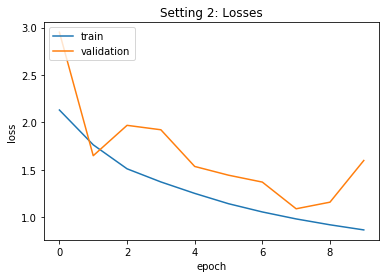

In [135]:
plt.ylim(0, 1)  
plt.plot(RDS_ta)
plt.plot(RDS_va)
plt.title('Setting 2: Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(RDS_tl)
plt.plot(RDS_vl)
plt.title('Setting 2: Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###### Setting 3: Relu Activation, with dropout and adam optimizer with non augmented data, call it RDAN

In [162]:
RDAN_tl = training_losses
RDAN_vl = validation_losses
RDAN_ta = training_accuracies
RDAN_va = validation_accuracies

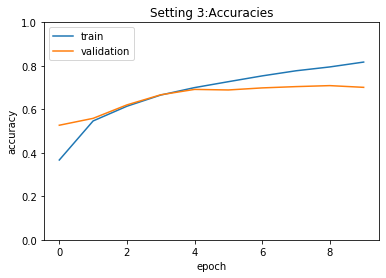

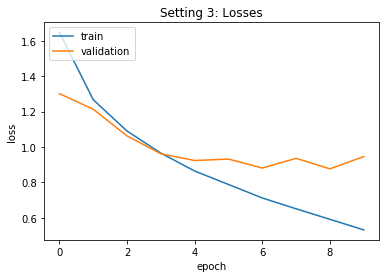

In [163]:
plt.ylim(0, 1)  
plt.plot(RDAN_ta)
plt.plot(RDAN_va)
plt.title('Setting 3:Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

 
plt.plot(RDAN_tl)
plt.plot(RDAN_vl)
plt.title('Setting 3: Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###### Setting 4: Using Relu activation, with dropout and SGD Optimizer,call it RDSN, Non augmented data

In [179]:
RDSN_tl = training_losses
RDSN_vl = validation_losses
RDSN_ta = training_accuracies
RDSN_va = validation_accuracies

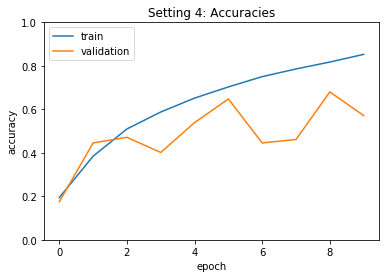

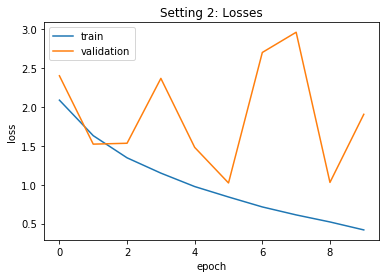

In [180]:
plt.ylim(0, 1)  
plt.plot(RDSN_ta)
plt.plot(RDSN_va)
plt.title('Setting 4: Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(RDSN_tl)
plt.plot(RDSN_vl)
plt.title('Setting 2: Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###### All 4 accuracies comparision

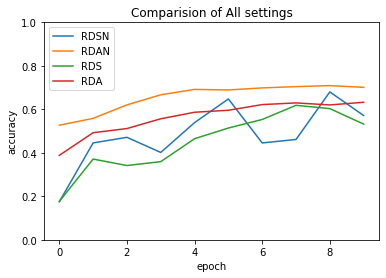

In [181]:
plt.ylim(0, 1)
plt.plot(RDSN_va)
plt.plot(RDAN_va)
plt.plot(RDS_va)
plt.plot(RDA_va)
plt.title('Comparision of All settings')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['RDSN', 'RDAN','RDS','RDA'], loc='upper left')
plt.show()